### 5.1 Introduction to convnets

先用convnet搭一个LeNet5在MNIST跑一下，看看和之前两层Dense的结果有何区别(精度约97.8%)：

In [1]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

C:\Users\10750\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


In [3]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                36928     
__________

In [4]:
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
60000/60000 [==============================] - 42s 701us/step - loss: 0.1666 - acc: 0.9484
Epoch 2/5
60000/60000 [==============================] - 14s 237us/step - loss: 0.0466 - acc: 0.98570s - loss: 0.0468 - acc: 0.9
Epoch 3/5
60000/60000 [==============================] - 14s 235us/step - loss: 0.0315 - acc: 0.99021s -  - ETA: 0s - loss: 0.0314 - acc: 0.990
Epoch 4/5
60000/60000 [==============================] - 14s 235us/step - loss: 0.0240 - acc: 0.99290s - loss: 0.0242 - 
Epoch 5/5
60000/60000 [==============================] - 15s 246us/step - loss: 0.0189 - acc: 0.9943


In [5]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 2s 167us/step


In [6]:
test_acc

0.9895

之所以使用convnet得到的结果要更好，是因为其性质和视觉空间的以下两个性质相契合：
- 卷积神经网络学到的模式具有平移不变性
- 卷积神经网络可以学到模式的空间层次(每一层feature map的表示抽象程度提高，这也是采用pooling做下采样的重要原因)

### 5.2 Training a convnet from scratch on a small dataset

这一节我们从原始数据集训练一个模型来做二分类。使用的是kaggle上cat-vs-dog比赛数据集的一个子集。因为我们只用4000张图像，其中2000张用于训练，1000张用于验证，1000张用于测试，这个数据体量是很容易过拟合的。因此这一节中我们采用data augmentation对图像进行处理。

In [9]:
import os, shutil

original_dataset_dir = r'C:\Users\10750\Desktop\notebook\datasets\catvsdog\train'

base_dir = r'C:\Users\10750\Desktop\notebook\datasets\catvsdog\dataset_4000'
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir,'test')
os.mkdir(test_dir)

train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [12]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                       input_shape=(150, 150, 3)))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3),activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)       147584    
__________

In [15]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

在把数据feed到模型中前，我们要先对数据进行预处理，将JPEG格式的数据处理为浮点型张量的格式。具体步骤如下:

1. 读取图像文件
2. 将JPEG文件解码为RGB grids
3. 将RGB grids转换为浮点数张量
4. 将像素值缩放到[0, 1]区间

Keras有着自动完成这些步骤的工具。keras.preprocessing.image中有一个图像处理辅助工具的模块。ImageDataGenerator可以快速创建python生成器，将硬盘上的图像文件自动处理为preprocessed张量batch。

In [17]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# class由不同train_dir下不同dir名称决定
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [18]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


In [19]:
# fit_generator方法适用于要fit的数据在磁盘而非内存上，并采用
# generator生成数据，其可以在generator上fit数据
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/30
100/100 [==============================] - 97s 971ms/step - loss: 0.6891 - acc: 0.5365 - val_loss: 0.6973 - val_acc: 0.5000
Epoch 2/30
100/100 [==============================] - 42s 423ms/step - loss: 0.6622 - acc: 0.6055 - val_loss: 0.6779 - val_acc: 0.5540
Epoch 3/30
100/100 [==============================] - 90s 904ms/step - loss: 0.6353 - acc: 0.6500 - val_loss: 0.6354 - val_acc: 0.6330
Epoch 4/30
100/100 [==============================] - 40s 401ms/step - loss: 0.5923 - acc: 0.6835 - val_loss: 0.6353 - val_acc: 0.6300
Epoch 5/30
100/100 [==============================] - 23s 225ms/step - loss: 0.5494 - acc: 0.7225 - val_loss: 0.5929 - val_acc: 0.6710
Epoch 6/30
100/100 [==============================] - 19s 188ms/step - loss: 0.5208 - acc: 0.7345 - val_loss: 0.5877 - val_acc: 0.6810
Epoch 7/30
100/100 [==============================] - 18s 183ms/step - loss: 0.4880 - acc: 0.7645 - val_loss: 0.5742 - val_acc: 0.6970
Epoch 8/30
100/100 [==============================] - 1

In [20]:
model.save('cats_and_dogs_small_1.h5')

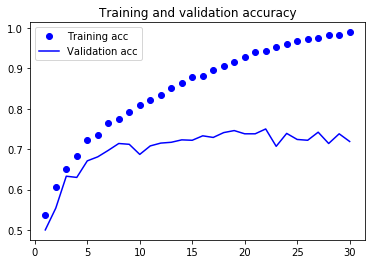

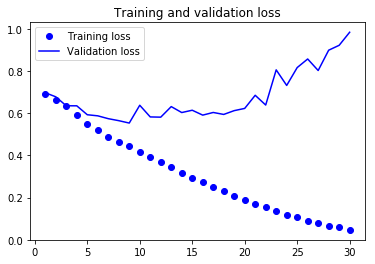

In [21]:
# 绘制loss和acc曲线
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

从以上曲线中可以明显看出过拟合的情况，这是由于学习样本的数目过少。下面我们用Keras中的ImageDataGenerator做数据增强：

In [22]:
datagen = ImageDataGenerator(
    rotation_range=40,         # 图像随机旋转的角度值
    width_shift_range=0.2,     # 图像在水平方向上平移的范围
    height_shift_range=0.2,    # 图像在竖直方向上平移的范围
    shear_range=0.2,           # 随机错切变换的角度
    zoom_range=0.2,            # 随机缩放的范围
    horizontal_flip=True,      # 随机将一半图像水平翻转
    fill_mode='nearest')       # 填充新像素的方法

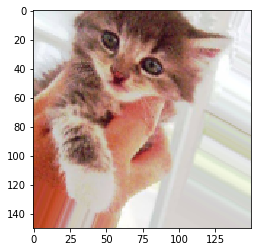

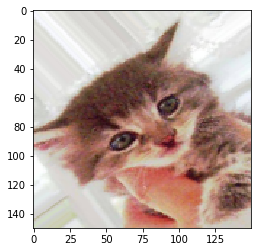

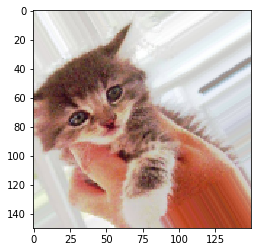

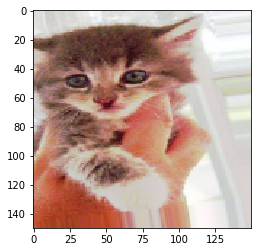

In [23]:
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for
         fname in os.listdir(train_cats_dir)]

img_path = fnames[3]

img = image.load_img(img_path, target_size=(150, 150))

x = image.img_to_array(img)

x = x.reshape((1, ) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgpolt = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i%4 == 0:
        break
plt.show()

In [25]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
            input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-4),
    metrics=['acc'])

In [26]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

In [27]:
# 不能对验证集做augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

In [28]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 120s 1s/step - loss: 0.6937 - acc: 0.5078 - val_loss: 0.6813 - val_acc: 0.5470
Epoch 2/100
100/100 [==============================] - 48s 480ms/step - loss: 0.6840 - acc: 0.5634 - val_loss: 0.6709 - val_acc: 0.5480
Epoch 3/100
100/100 [==============================] - 58s 578ms/step - loss: 0.6699 - acc: 0.5888 - val_loss: 0.6591 - val_acc: 0.5860
Epoch 4/100
100/100 [==============================] - 47s 468ms/step - loss: 0.6593 - acc: 0.5994 - val_loss: 0.6476 - val_acc: 0.6080
Epoch 5/100
100/100 [==============================] - 44s 436ms/step - loss: 0.6430 - acc: 0.6253 - val_loss: 0.6513 - val_acc: 0.6060
Epoch 6/100
100/100 [==============================] - 42s 421ms/step - loss: 0.6279 - acc: 0.6566 - val_loss: 0.6122 - val_acc: 0.6530
Epoch 7/100
100/100 [==============================] - 44s 440ms/step - loss: 0.6182 - acc: 0.6606 - v

100/100 [==============================] - 37s 366ms/step - loss: 0.4290 - acc: 0.8000 - val_loss: 0.4122 - val_acc: 0.8070
Epoch 61/100
100/100 [==============================] - 36s 364ms/step - loss: 0.4153 - acc: 0.8100 - val_loss: 0.4394 - val_acc: 0.7880
Epoch 62/100
100/100 [==============================] - 37s 371ms/step - loss: 0.4179 - acc: 0.8081 - val_loss: 0.4136 - val_acc: 0.8140
Epoch 63/100
100/100 [==============================] - 37s 370ms/step - loss: 0.4029 - acc: 0.8172 - val_loss: 0.4025 - val_acc: 0.8130
Epoch 64/100
100/100 [==============================] - 37s 366ms/step - loss: 0.4057 - acc: 0.8178 - val_loss: 0.4125 - val_acc: 0.8040
Epoch 65/100
100/100 [==============================] - 37s 370ms/step - loss: 0.4006 - acc: 0.8184 - val_loss: 0.4527 - val_acc: 0.7840
Epoch 66/100
100/100 [==============================] - 36s 360ms/step - loss: 0.4135 - acc: 0.8184 - val_loss: 0.4067 - val_acc: 0.8200
Epoch 67/100
100/100 [==============================] 

In [29]:
model.save('cats_and_dogs_small_2.h5')

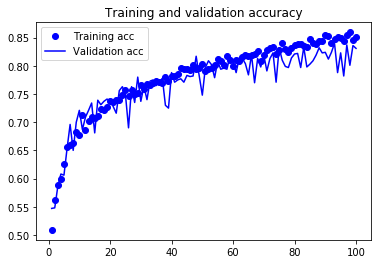

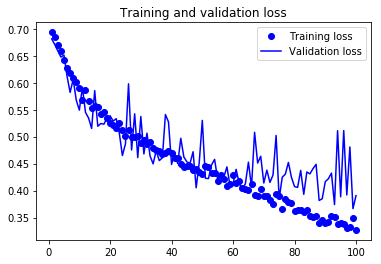

In [30]:
# 绘制loss和acc曲线
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 5.3 Using a pretrained convnet

想要将深度学习应用于小型图像数据集，一种常用且非常高效的方法是使用预训练网络。预训练网络（pretrained network）是一个保存好的网络，之前已在大型数据集（通常是大规模图像分类任务）上训练好。如果这个原始数据集足够大且足够通用，那么**预训练网络学到的特征的空间层次结构可以有效地作为视觉世界的通用模型**，因此这些特征可用于各种不同的计算机视觉问题，即使这些新问题涉及的类别和原始任务完全不同。

这种学到的特征在不同问题之间的可移植性，是深度学习相比早期浅层学习方法的重要优势，它使得深度学习对小数据问题非常有效。

使用pretrained network有以下两种方法: feature extraction特征提取和fine-tuning微调模型。

#### 5.3.1 Feature extraction
所谓特征提取，即复用预训练模型中的convolutional base，在其feature map后重新训练一个新的分类器(Dense层的连接)。之所以这么做是因为convoltional layer学到的表示要更加通用。

下面我们从keras.applications中导入VGG16，并在其基础上训练一个新的模型：

In [ ]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  )